In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

In [3]:
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

In [4]:
merged_data = transactions.merge(customers, on='CustomerID', how='left')

In [5]:
customer_features = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',         # Total purchase value
    'Quantity': 'sum',          # Total quantity purchased
    'ProductID': 'nunique',     # Number of unique products purchased
    'TransactionID': 'count',   # Number of transactions
    'Region': 'first',          # Region (categorical)
    'SignupDate': 'first'       # Signup date
}).reset_index()

In [6]:
customer_features = pd.get_dummies(customer_features, columns=['Region'], drop_first=True)

In [7]:
customer_features['SignupDays'] = (customer_features['SignupDate'].max() - customer_features['SignupDate']).dt.days
customer_features.drop(columns=['SignupDate'], inplace=True)

In [8]:
scaler = StandardScaler()
numeric_cols = ['TotalValue', 'Quantity', 'ProductID', 'TransactionID', 'SignupDays']
customer_features[numeric_cols] = scaler.fit_transform(customer_features[numeric_cols])

In [12]:
num_clusters = 5  # Flexible between 2 and 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(customer_features[numeric_cols])

In [13]:
db_index = davies_bouldin_score(customer_features[numeric_cols], customer_features['Cluster'])
silhouette_avg = silhouette_score(customer_features[numeric_cols], customer_features['Cluster'])

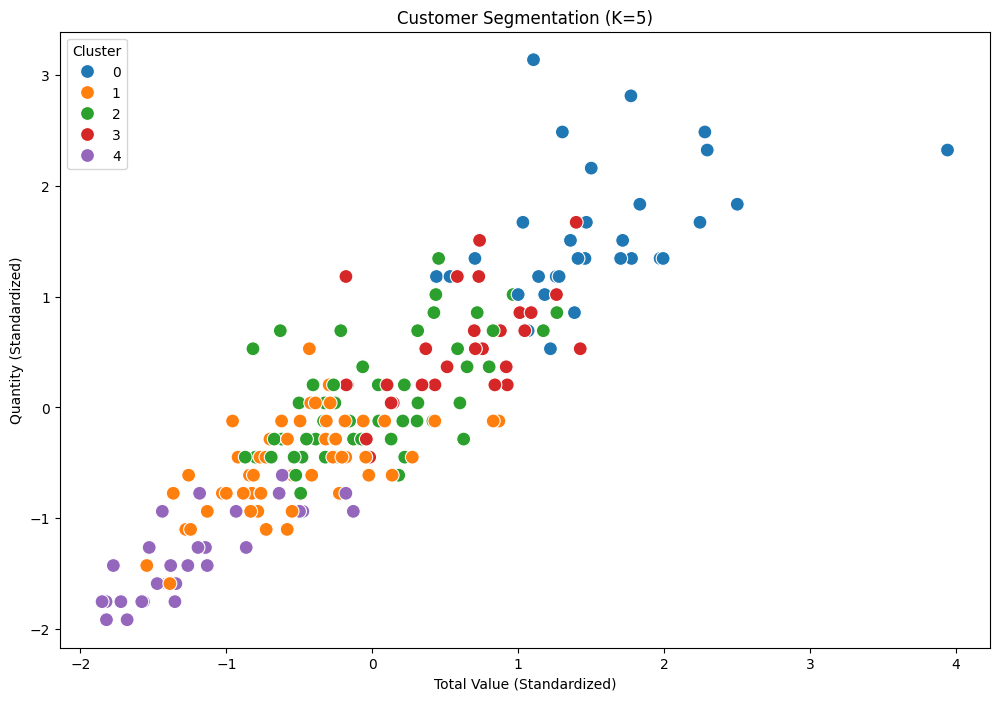

In [14]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=customer_features['TotalValue'], 
    y=customer_features['Quantity'], 
    hue=customer_features['Cluster'], 
    palette='tab10', 
    s=100
)
plt.title(f'Customer Segmentation (K={num_clusters})')
plt.xlabel('Total Value (Standardized)')
plt.ylabel('Quantity (Standardized)')
plt.legend(title='Cluster')
plt.show()

In [25]:
from fpdf import FPDF

pdf = FPDF()
pdf.add_page()
pdf.set_font("Arial", "B", 16)
pdf.cell(0, 10, "Clustering Report", ln=True, align="C")
pdf.set_font("Arial", "", 12)
pdf.cell(0, 10, f"Number of Clusters Formed: {num_clusters}", ln=True)
pdf.cell(0, 10, f"Davies-Bouldin Index: {db_index:.4f}", ln=True)
pdf.cell(0, 10, f"Silhouette Score: {silhouette_avg:.4f}", ln=True)
pdf.image("cluster.png", w=150, h=100)
pdf.set_font("Arial", "B", 16)
pdf.cell(0, 10, "Clustering Plot Explanation:", ln=True)
pdf.set_font("Arial", "", 12)
pdf.multi_cell(0, 10, "The plot visualizes customer segments based on their standardized total purchase value and total quantity purchased.  Each point represents a customer, colored according to the cluster to which it belongs.  Clusters are formed by the KMeans algorithm, aiming to group customers with similar spending behavior.  Customers within the same cluster exhibit a similar combination of total spending and quantities bought.")
pdf.set_font("Arial", "B", 16)
pdf.cell(0, 10, "\nObservations from the clustering results:", ln=True)
pdf.set_font("Arial", "", 12)
pdf.multi_cell(0, 10, "The plot reveals distinct customer groups. Observe the cluster density and separation to infer buying habits. Clusters with high total value and quantity may represent high-value customers, while others may represent budget-conscious shoppers or those who purchase items in smaller amounts. Further analysis could correlate these clusters with other customer attributes and characteristics to gain deeper insights into business strategies.")
pdf.output("Anuneet_Rastogi_Clustering.pdf")

''